In [1]:
import os
os.environ["CPP_TF_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd

In [2]:
tf.random.set_seed(47)

In [3]:
metrics = [tf.keras.metrics.RootMeanSquaredError()]

2022-10-06 16:20:48.909310: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
train_ds = pd.read_csv("../input/feedback-prize-english-language-learning/train.csv")
test_ds = pd.read_csv("../input/feedback-prize-english-language-learning/test.csv")

In [5]:
print(train_ds.shape)
train_ds.head()

(3911, 8)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
print(test_ds.shape)
test_ds.head()

(3, 2)


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [7]:
train_features = train_ds.pop("full_text")
train_ds.pop("text_id")
train_labels = train_ds

num_classes = train_labels.shape[-1]

In [8]:
train_features.head()

0    I think that students would benefit from learn...
1    When a problem is a change you have to let it ...
2    Dear, Principal\n\nIf u change the school poli...
3    The best time in life is when you become yours...
4    Small act of kindness can impact in other peop...
Name: full_text, dtype: object

In [9]:
train_labels.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels))

tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=3911>

In [11]:
train_ds = train_ds.cache().batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
val_ds = train_ds.take(15)
train_ds = train_ds.skip(15)

In [13]:
for text_batch, label_batch in train_ds.take(1):
  print(f"Text: {text_batch[0]}")
  print(f"Labels: {label_batch[0]}")

Text: b'Students and Families should be left to decide if they want to get involved in extracurricular activities. Students should know what they want to do like get involved in more or less extracurricular activities. Teachers say students get stressed over more extracurricular activities. That is not true students do not get stressed over extracurricular activities. Students should have their own choice if they wish to take ore extracurricular work.\n\nStudents and Families should be allowed to pick if they want ht o continue extracurricular activities or not, and if it is too much for the student to handle in one day. because the overload of activities they do. I believe the school should not get involved at all and let the students have responsibilities to handle their situation. For example a student will be able to decide whether or not they wish to take an extracurricular activities event.\n\nStudents have reasons on why they should be able to settle it with their families. One 

2022-10-06 16:20:49.614705: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
import re
import string

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped = tf.strings.regex_replace(lowercase, '\n', ' ')
  return tf.strings.regex_replace(stripped, f"[{re.escape(string.punctuation)}]", '')

In [15]:
vocab_size = 20000  # Should be relatively high as there are misspellings
sequence_length = 200

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_sequence_length=200
)

In [16]:
text_ds = train_ds.map(lambda x, y: x)

In [17]:
vectorize_layer.adapt(text_ds)
vectorize_layer.get_vocabulary()[:20]

2022-10-06 16:20:49.987579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


['',
 '[UNK]',
 'to',
 'the',
 'and',
 'you',
 'a',
 'that',
 'in',
 'they',
 'is',
 'i',
 'of',
 'have',
 'for',
 'be',
 'it',
 'can',
 'because',
 'people']

In [18]:
embedding_dim = 32

def get_model():
  model = tf.keras.Sequential([
      vectorize_layer,
      layers.Embedding(vocab_size, embedding_dim, name="Embedding"),
      layers.GlobalAveragePooling1D(),
      layers.Dense(32, activation="relu"),
      layers.Dense(num_classes)
  ])

  return model

In [19]:
model = get_model()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 32)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 641,254
Trainable params: 641,254
Non-trainable params: 0
_________________________________________________________________


In [21]:
def mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true-y_pred))

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=mean_squared_error,
    metrics=metrics
)

In [23]:
EPOCHS = 5

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        tf.keras.callbacks.TensorBoard()
    ]
)

Epoch 1/5


2022-10-06 16:20:50.929607: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-06 16:20:50.929671: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-06 16:20:50.931049: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 13/108 [==>...........................] - ETA: 1s - loss: 9.9551 - root_mean_squared_error: 3.1552

2022-10-06 16:20:51.918214: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-06 16:20:51.918280: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-06 16:20:51.935473: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-06 16:20:51.939022: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-06 16:20:51.954106: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_06_16_20_51

2022-10-06 16:20:51.955773: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_10_06_16_20_51/26351478340f.trace.json.gz
2022-10-06 16:20:51.974355: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_06_16_20_51

2022-10-06 16:20:51.975355: I

108/108 [==============================] - 3s 15ms/step - loss: 5.9302 - root_mean_squared_error: 2.4352 - val_loss: 0.6265 - val_root_mean_squared_error: 0.7915
Epoch 2/5
108/108 [==============================] - 1s 12ms/step - loss: 0.4365 - root_mean_squared_error: 0.6607 - val_loss: 0.4430 - val_root_mean_squared_error: 0.6656
Epoch 3/5
108/108 [==============================] - 1s 12ms/step - loss: 0.3785 - root_mean_squared_error: 0.6153 - val_loss: 0.4091 - val_root_mean_squared_error: 0.6396
Epoch 4/5
108/108 [==============================] - 1s 12ms/step - loss: 0.3422 - root_mean_squared_error: 0.5850 - val_loss: 0.3815 - val_root_mean_squared_error: 0.6177
Epoch 5/5
108/108 [==============================] - 2s 14ms/step - loss: 0.3131 - root_mean_squared_error: 0.5596 - val_loss: 0.3606 - val_root_mean_squared_error: 0.6005


In [24]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


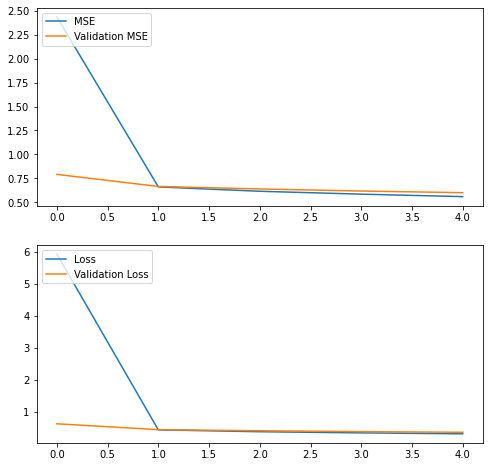

In [25]:
mse = history.history["root_mean_squared_error"]
val_mse = history.history["val_root_mean_squared_error"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.plot(mse, label="MSE")
plt.plot(val_mse, label="Validation MSE")
plt.legend(loc="upper left")

plt.subplot(2,1,2)
plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper left")

plt.show()

In [26]:
text = [
    "Writing is a foundational skill. Sadly, it's one few students are able to hone, often because writing tasks are infrequently assigned in school. A rapidly growing student population, students learning English as a second language, known as English Language Learners (ELLs), are especially affected by the lack of practice. While automated feedback tools make it easier for teachers to assign more writing tasks, they are not designed with ELLs in mind.Competition host Vanderbilt University is a private research university in Nashville, Tennessee. It offers 70 undergraduate majors and a full range of graduate and professional degrees across 10 schools and colleges, all on a beautiful campus—an accredited arboretum—complete with athletic facilities and state-of-the-art laboratories. Vanderbilt is optimized to inspire and nurture cross-disciplinary research that fosters discoveries that have global impact. Vanderbilt and co-host, The Learning Agency Lab, an independent nonprofit based in Arizona, are focused on developing science of learning-based tools and programs for social good."
]

prediction = model.predict(text)
print(prediction)

[[2.481571  2.4062898 2.5845876 2.4623208 2.4033098 2.4406168]]
